# The Implementation of Custom Keras Layer for Vision Transformer with Custom Keras Metric F1 score

## Introduction

This ipynb notebook is created to document the results of my self-study on `Custom Keras Layers Implementation`.<br>
I have developed `Vision Transformer (ViT)` model layers from scratch and utilized them for an image classification task.<br>
Additionally, I implemented the custom Keras metric `F1 score` to evaluate the model during training.

**NOTE** 
- This ipynb notebook primarily demonstrates the complete coding cycle for creating, training, and evaluating the model.

## Version

In [1]:
from module.utility.Initializer import Initializer
# Display version of TensorFlow and Python
Initializer.show_version()

# Display Version of Nvidia Driver and CUDA
!nvidia-smi

TensorFlow version: 2.6.0
Python version: 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
Fri Nov 10 13:58:53 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P0              20W /  80W |    339MiB /  6144MiB |      4%      Default |
|                                         |     

## Configuration

In [2]:
import tensorflow as tf

CFG = {
    "fp16": False, # Use mixed precision training (True/False)
    "dataset_dir": ".\DATASET\ILLUSTRATION VS MANGA", 
    "extension": [".jpg", ".png"],
    "image_size": 224,
    "patch_size": 32, # Increase patch size from 16 to 32 for faster computation
    # Vit-Base
    "num_head": 12,
    "latent_size": 768,
    "mlp_size": 3072,
    "trans_layer": 12,
    # Other
    "batch": 32, # Batch size
    "optimizer1": tf.keras.optimizers.Adam(learning_rate=1e-4), # main training
    "optimizer2": tf.keras.optimizers.Adam(learning_rate=1e-6, decay=1e-4), # fine-tuning
    "loss_func": tf.losses.CategoricalCrossentropy(), # Loss function (Categorical Cross-Entropy)
}

## Initializing

In [3]:
if CFG["fp16"]:
    Initializer.mixed_precision16()

Initializer.memory_growth()

## Dataset preparation

In [4]:
from module.utility.DirectoryProcessor import DirectoryProcessor
from pathlib import Path

def data_maker():
    # File path processing
    data_list = []
    label_set = set()
    path_list = DirectoryProcessor.get_only_files(CFG["dataset_dir"], CFG["extension"], include_sub_dir=True)

    for path in path_list:
        path_obj = Path(path)
        label = path_obj.parts[-2]
        data_list.append((path, label))
        label_set.add(label)
    
    label_list = list(sorted(label_set))

    return data_list, label_list

data_list, label_list = data_maker()

Total: 1157 dataset including
ILLUSTRATION: 951
MANGA: 206
=====
Train: 370 dataset including
ILLUSTRATION: 185
MANGA: 185
Class weight: {'ILLUSTRATION': 1.0, 'MANGA': 1.0}
=====
Test: 42 dataset including
ILLUSTRATION: 21
MANGA: 21


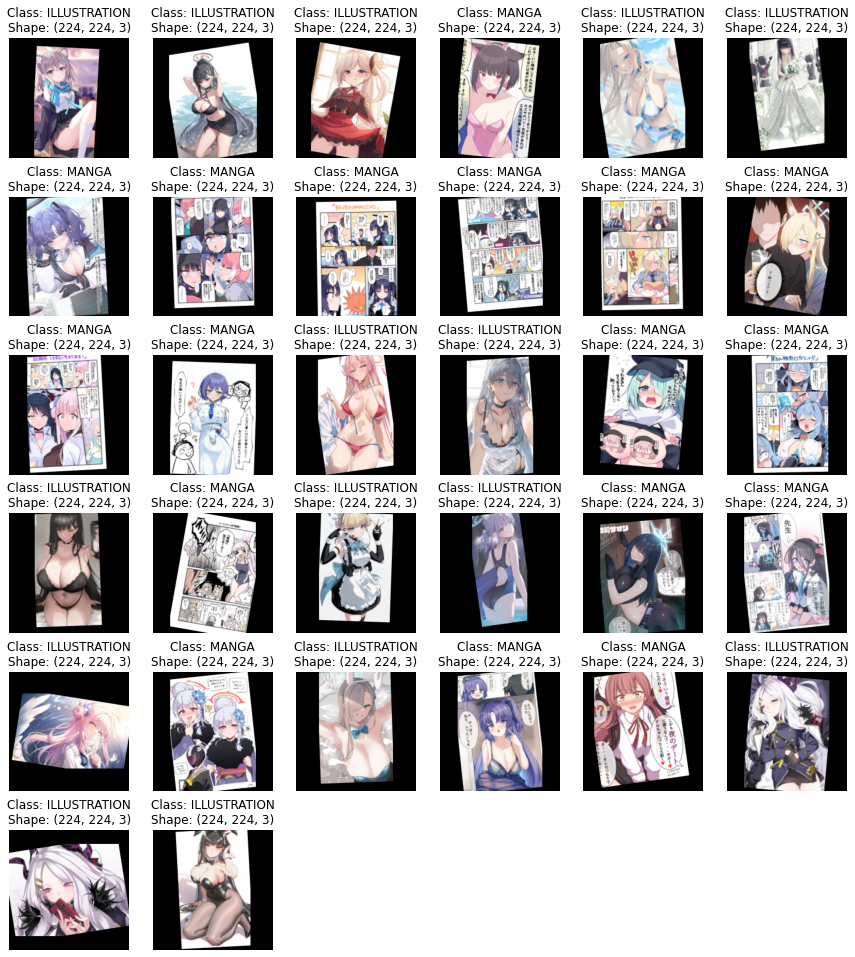

In [5]:
from module.image_classification.ImageDataGenerator import ImageDataGenerator
from module.image_classification.ImageVisualizer import ImageVisualizer as vis

# Calling data generator instance 
generator = ImageDataGenerator(
    input = data_list,
    image_size = CFG["image_size"],
    keep_aspect_ratio = True,
    label_mode = "onehot",
    horizontal_flip = False,
    vertical_flip = False,
    translate_range = 0.1,
    rotation_range = 10,
    border_method = "constant", # "constant" or "replicate"
    validation_split = 0.1,
)

# Generate dataset
#train, test = generator.generate_dataset_from_generator(batch_size=CFG["batch"], balance=True, train_drop_remainder=True) # for low memory
train, test = generator.generate_dataset_from_tensor_slices(batch_size=CFG["batch"], balance=True, train_drop_remainder=True) # for high memory

# Visualizing
vis.display_batch(train, label_list, figsize=(15, 17))

## Model creation

In [6]:
from model.VisionTransformer import VisionTransformer as ViT

model = ViT(
    image_size      = CFG["image_size"],
    patch_size      = CFG["patch_size"],
    num_class       = len(label_list),
    num_head        = CFG["num_head"],
    latent_size     = CFG["latent_size"],
    num_transformer = CFG["trans_layer"],
    mlp_size        = CFG["mlp_size"]
)

"""
This code below give the same model

from model.VisionTransformer import ViTBase

model = ViTBase(
    image_size  = CFG["image_size"],
    patch_size  = CFG["patch_size"],
    num_class   = len(label_list),
)
"""
model.summary()

Model: "ViT_I224x224_P32_L12_H12_D768_MLP3072_2Class"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_image (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
Image_Patcher (ImagePatcher) (None, 49, 3072)          0         
_________________________________________________________________
Patch_Encoder (PatchEncoder) (None, 49, 768)           2397696   
_________________________________________________________________
ClassToken (ClassToken)      (None, 50, 768)           768       
_________________________________________________________________
Transformer_Encoder_1 (Trans (None, 50, 768)           7087872   
_________________________________________________________________
Transformer_Encoder_2 (Trans (None, 50, 768)           7087872   
_________________________________________________________________
Transformer_Encoder_3 

## Model training

In [7]:
from module.metric.F1Score import F1Score as F1

### Main training

In [8]:
# Create an Early Stopping callback that monitors validation loss and stops training if it doesn't improve significantly
EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0.01, 
    patience = 5, 
    restore_best_weights = True, 
    verbose = 1,
)

# Compile the model with the specified optimizer and loss function
model.compile(optimizer=CFG["optimizer1"], loss=CFG["loss_func"], metrics=["accuracy", F1()])

# Train the model on the training dataset with early stopping and a maximum of 100 epochs
model.train(train, test, epochs=1000, callbacks=[EarlyStop])

Epoch 1/1000
11/11 [==============================] - 18s 693ms/step - loss: 3.8648 - accuracy: 0.4858 - f1: 0.4858 - val_loss: 0.9300 - val_accuracy: 0.5000 - val_f1: 0.5000
Epoch 2/1000
11/11 [==============================] - 4s 416ms/step - loss: 0.8465 - accuracy: 0.4631 - f1: 0.4631 - val_loss: 0.6895 - val_accuracy: 0.5000 - val_f1: 0.5000
Epoch 3/1000
11/11 [==============================] - 5s 422ms/step - loss: 0.6785 - accuracy: 0.5540 - f1: 0.5540 - val_loss: 0.6871 - val_accuracy: 0.5000 - val_f1: 0.5000
Epoch 4/1000
11/11 [==============================] - 4s 416ms/step - loss: 0.6743 - accuracy: 0.5511 - f1: 0.5511 - val_loss: 0.6698 - val_accuracy: 0.5238 - val_f1: 0.5238
Epoch 5/1000
11/11 [==============================] - 4s 417ms/step - loss: 0.6505 - accuracy: 0.6250 - f1: 0.6250 - val_loss: 0.6209 - val_accuracy: 0.6667 - val_f1: 0.6667
Epoch 6/1000
11/11 [==============================] - 5s 424ms/step - loss: 0.6722 - accuracy: 0.5994 - f1: 0.5994 - val_loss: 0.

### Fine tuning

In [9]:
# Create an Early Stopping callback that monitors validation loss and stops training if it doesn't improve significantly
EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0.01, 
    patience = 5, 
    restore_best_weights = True, 
    verbose = 1,
)

# Compile the model with the specified optimizer and loss function
model.compile(optimizer=CFG["optimizer2"], loss=CFG["loss_func"], metrics=["accuracy", F1()])

# Train the model on the training dataset with early stopping and a maximum of 100 epochs
model.train(train, test, epochs=1000, callbacks=[EarlyStop])

Continuing training from epoch 13
Epoch 14/1000
11/11 [==============================] - 17s 619ms/step - loss: 0.5673 - accuracy: 0.7216 - f1: 0.7216 - val_loss: 0.5317 - val_accuracy: 0.7381 - val_f1: 0.7381
Epoch 15/1000
11/11 [==============================] - 4s 409ms/step - loss: 0.5670 - accuracy: 0.7188 - f1: 0.7187 - val_loss: 0.5178 - val_accuracy: 0.7381 - val_f1: 0.7381
Epoch 16/1000
11/11 [==============================] - 4s 410ms/step - loss: 0.5708 - accuracy: 0.7131 - f1: 0.7131 - val_loss: 0.5256 - val_accuracy: 0.7619 - val_f1: 0.7619
Epoch 17/1000
11/11 [==============================] - 4s 418ms/step - loss: 0.5596 - accuracy: 0.7188 - f1: 0.7187 - val_loss: 0.5277 - val_accuracy: 0.7381 - val_f1: 0.7381
Epoch 18/1000
11/11 [==============================] - 5s 420ms/step - loss: 0.5642 - accuracy: 0.7045 - f1: 0.7045 - val_loss: 0.5290 - val_accuracy: 0.7381 - val_f1: 0.7381
Epoch 19/1000
11/11 [==============================] - 4s 414ms/step - loss: 0.5603 - accu

## Export model

In [10]:
model.save()

## Evaluation

### History graph

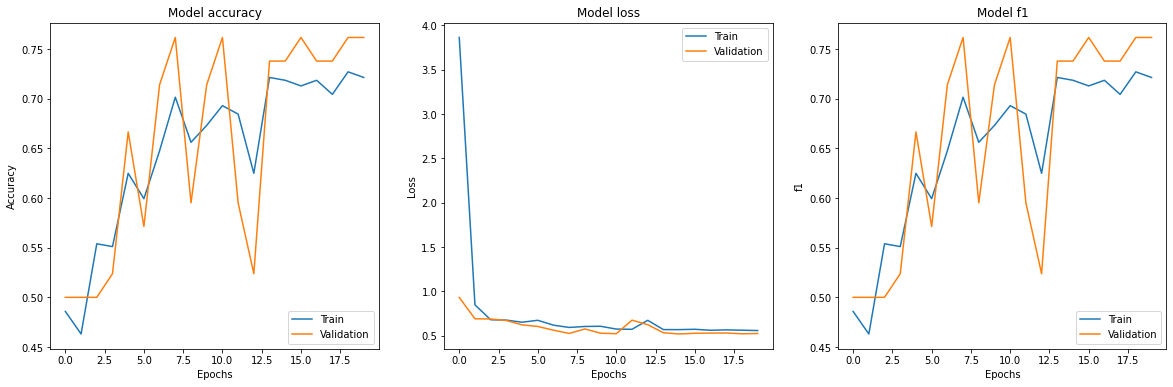

In [11]:
import matplotlib.pyplot as plt
def plot_training_history(history):
    plt.figure(figsize=(20, 6))
    
    # Summarize history for accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'])
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Summarize history for loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'])
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Summarize history for f1
    plt.subplot(1, 3, 3)
    plt.plot(history.history['f1'])
    if 'val_f1' in history.history:
        plt.plot(history.history['val_f1'])
    plt.title('Model f1')
    plt.ylabel('f1')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    plt.show()

plot_training_history(model.history)

**NOTE** 
- Training the Vision Transformer is more challenge than training CNN-based model architectures (e.g., ResNet, VGG) because Transformer-based architectures require `a significantly larger amount of data` compared to CNN-based architectures.